In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
        'modsim.py')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from modsim import *
from collections import namedtuple

In [3]:
# Membaca data dari file CSV
data_populasi = pd.read_csv("world-population-by-country-2020.csv")
data_populasi.rename(columns={"no": "No", "Country (or dependency)": "Country","Fert. Rate":"Fertility Rate"}, inplace=True)
selected_columns = data_populasi[["Country", "Population 2020", "Yearly Change", "Migrants (net)", "Land Area (Km²)", "Density (P/Km²)", "Fertility Rate"]]

In [4]:
# Cek 24 baris pertama untuk memahami struktur data
selected_columns.head(20)

,Country,Population 2020,Yearly Change,Migrants (net),Land Area (Km²),Density (P/Km²),Fertility Rate
0,China,"1,439,323,776",0.39%,"-348,399","9,388,211",153,1.7
1,India,"1,380,004,385",0.99%,"-532,687","2,973,190",464,2.2
2,United States,"331,002,651",0.59%,"954,806","9,147,420",36,1.8
3,Indonesia,"273,523,615",1.07%,"-98,955","1,811,570",151,2.3
4,Pakistan,"220,892,340",2.00%,"-233,379","770,880",287,3.6
5,Brazil,"212,559,417",0.72%,"21,200","8,358,140",25,1.7
6,Nigeria,"206,139,589",2.58%,"-60,000","910,770",226,5.4
7,Bangladesh,"164,689,383",1.01%,"-369,501","130,170","1,265",2.1
8,Russia,"145,934,462",0.04%,"182,456","16,376,870",9,1.8
9,Mexico,"128,932,753",1.06%,"-60,000","1,943,950",66,2.1


In [5]:
# Definisi namedtuple untuk State dan System
State = namedtuple('State', ['population'])
System = namedtuple('System', ['population', 'yearly_change', 'migrants', 'land_area', 'density', 'fertility_rate'])

# Fungsi untuk membuat sistem
def make_system(country):
    """Membuat obyek system untuk model populasi."""
    index = selected_columns[selected_columns['Country'] == country].index[0]
    return System(
        population=int(selected_columns['Population 2020'][index].replace(',', '')),
        yearly_change=float(selected_columns['Yearly Change'][index].strip('%')) / 100,
        migrants=int(selected_columns['Migrants (net)'][index].replace(',', '')),
        land_area=int(selected_columns['Land Area (Km²)'][index].replace(',', '')),
        density=int(selected_columns['Density (P/Km²)'][index].replace(',', '')),
        fertility_rate=float(selected_columns['Fertility Rate'][index])
    )


In [6]:
# Fungsi untuk memperbarui state dengan mempertimbangkan land area dan density
def update_func(state, t, system):
    """Fungsi untuk memperbarui populasi pada setiap langkah waktu."""
    births = system.fertility_rate * state.population / 1000
    net_migration = system.migrants / 1000
    population_change = births + net_migration + (system.yearly_change * state.population)
    
    # Pengaruh dari luas daratan dan kepadatan penduduk
    land_effect = system.land_area / 1_000_000  # Luas daratan dalam juta km²
    density_effect = (1 - (state.population / (system.density * system.land_area))) * 0.1
    
    # Modifikasi laju pertumbuhan populasi berdasarkan luas daratan dan kepadatan penduduk
    population_change *= (1 + land_effect + density_effect)
    
    new_population = state.population + population_change
    return State(population=new_population)


In [7]:
# Fungsi untuk menjalankan simulasi populasi
def run_population_simulation(system, years):
    """Menjalankan simulasi populasi."""
    state = State(population=system.population)
    results = pd.Series(dtype=float)
    results[0] = state.population
    
    for t in range(1, years + 1):
        state = update_func(state, t, system)
        results[t] = state.population
    
    return results


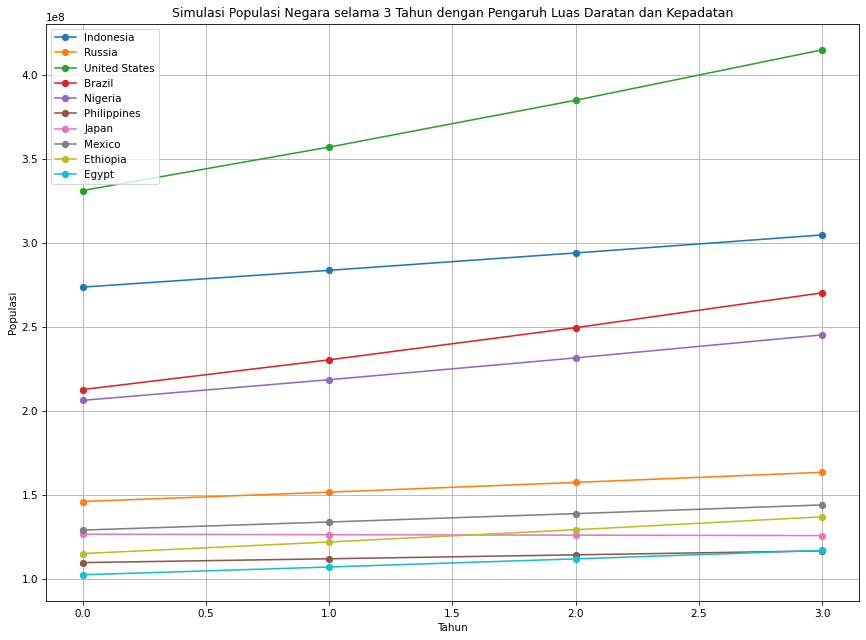

In [8]:
# Dictionary untuk menyimpan semua hasil simulasi
all_results = {}

# Lama simulasi dalam tahun
years = 3

# Menjalankan simulasi untuk semua negara
for country in selected_columns['Country']:
    system = make_system(country)
    results = run_population_simulation(system, years)
    all_results[country] = results

# Plot hasil simulasi untuk beberapa negara sebagai contoh
plt.figure(figsize=(14, 10))

# Plot untuk beberapa negara pilihan agar visualisasi lebih jelas
countries_to_plot = ['Indonesia', 'Russia', 'United States', 'Brazil', 'Nigeria', 'Philippines', 'Japan', 'Mexico', 'Ethiopia', 'Egypt']

for country in countries_to_plot:
    results = all_results[country]
    plt.plot(results.index, results, marker='o', label=country)

plt.title(f'Simulasi Populasi Negara selama {years} Tahun dengan Pengaruh Luas Daratan dan Kepadatan')
plt.xlabel('Tahun')
plt.ylabel('Populasi')
plt.legend()
plt.grid(True)
plt.show()

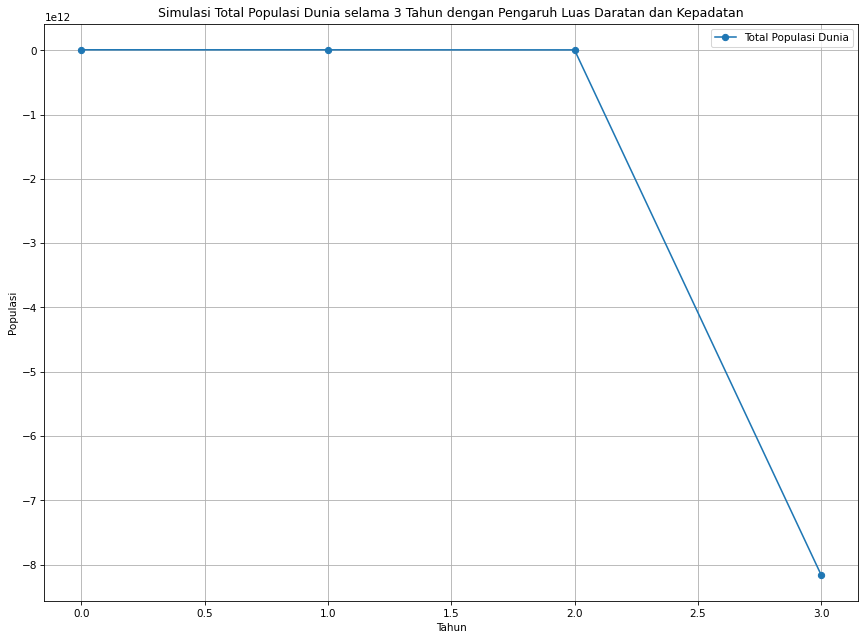

In [13]:
# Agregasi hasil simulasi untuk semua negara
total_population = pd.Series(dtype=float)
for country, results in all_results.items():
    if total_population.empty:
        total_population = results.copy()
    else:
        total_population += results

# Plot hasil agregasi
plt.figure(figsize=(14, 10))
plt.plot(total_population.index, total_population, marker='o', label='Total Populasi Dunia')
plt.title(f'Simulasi Total Populasi Dunia selama {years} Tahun dengan Pengaruh Luas Daratan dan Kepadatan')
plt.xlabel('Tahun')
plt.ylabel('Populasi')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Fungsi untuk membuat sistem
def make_system(country, fertility):
    """Membuat obyek system untuk model populasi."""
    index = selected_columns[selected_columns['Country'] == country].index[0]
    return System(
        population=int(selected_columns['Population 2020'][index].replace(',', '')),
        yearly_change=float(selected_columns['Yearly Change'][index].strip('%')) / 100,
        migrants=int(selected_columns['Migrants (net)'][index].replace(',', '')),
        land_area=int(selected_columns['Land Area (Km²)'][index].replace(',', '')),
        density=int(selected_columns['Density (P/Km²)'][index].replace(',', '')),
        fertility_rate=fertility
    )

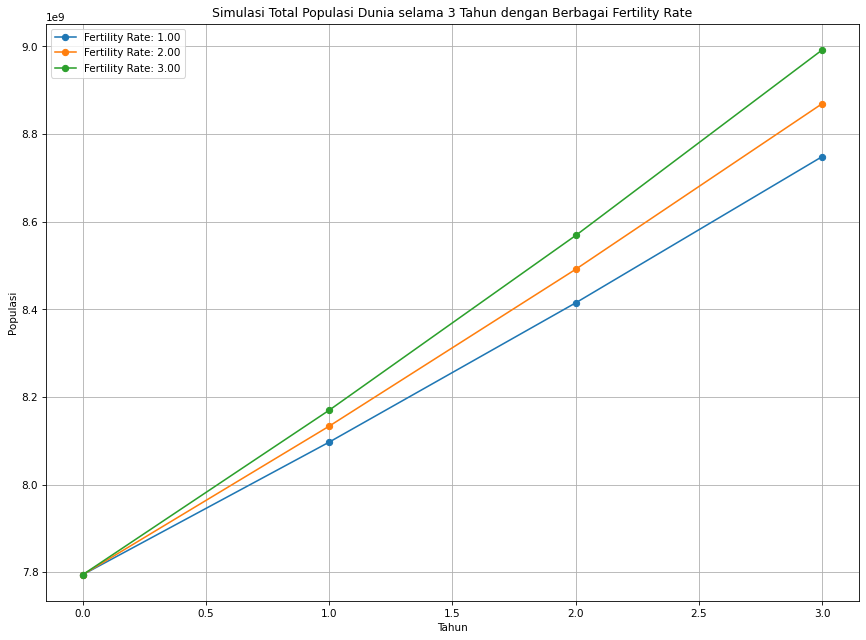

In [19]:
# Definisi sweep series untuk faktor fertility_rate
fertility_rate_sweep = np.linspace(1, 3, 3)

# Simpan hasil simulasi untuk setiap nilai fertility_rate dalam satu SweepSeries
total_population_sweep = SweepSeries()
for fertility_rate in fertility_rate_sweep:
    # Menjalankan simulasi untuk semua negara
    all_results = {}
    for country in selected_columns['Country']:
        system = make_system(country, fertility_rate)
        results = run_population_simulation(system, years)
        all_results[country] = results
    
    # Agregasi hasil simulasi untuk semua negara
    total_population = pd.Series(dtype=float)
    for country, results in all_results.items():
        if total_population.empty:
            total_population = results.copy()
        else:
            total_population += results
    
    # Simpan hasil populasi dunia ke dalam SweepSeries
    total_population_sweep[fertility_rate] = total_population

# Plot hasil SweepSeries
plt.figure(figsize=(14, 10))
for fertility_rate, total_population in total_population_sweep.items():
    plt.plot(total_population.index, total_population, marker='o', label=f'Fertility Rate: {fertility_rate:.2f}')

plt.title(f'Simulasi Total Populasi Dunia selama {years} Tahun dengan Berbagai Fertility Rate')
plt.xlabel('Tahun')
plt.ylabel('Populasi')
plt.legend()
plt.grid(True)
plt.show()
